# Creating node repesentation using `Word2Vec` in the `gensim` package
* Two approaches:
  * CBOW (continuous bag of word): provided context words, find target word
  * Skipgram: provided a target word, predict context words
* This notebook implement skipgram
  * Convert text to text list
  * Create model from Word2Vec
  * Train model for word embeddings
    * Word embeddings are numerical vector representing words

In [1]:
# split text to list
text = """
As of my last knowledge update in January 2022, there isn't a widely recognized concept 
or method known as the "cosmo method" in the context of quantum chemistry. However, it's 
possible that developments or new terminologies have emerged since then. In the realm of 
quantum chemistry, the COSMO (Conductor-like Screening Model) method is well-known.
COSMO is a continuum solvation model used to account for the effects of solvent in quantum
mechanical calculations. It is particularly useful for simulating reactions and properties
in solution by incorporating the electrostatic interactions between the solute and solvent.
If there have been updates or new developments related to "cosmo" in quantum chemistry after
2022, I recommend checking the latest literature, research papers, or the documentation of
relevant software packages for the most accurate and recent information.
""".split()

In [2]:
# create skipgrams with `CONTEXT_SIZE` context words before and after a target word
import numpy as np

CONTEXT_SIZE = 2

skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    # get array of `CONTEXT_SIZE` before and after the target word `text[i]`
    array = [text[j] for j in np.arange(i-CONTEXT_SIZE, i+CONTEXT_SIZE+1) if j != i]
    # add to skipgram list
    skipgrams.append((text[i], array))

# print first five skipgram elements
skipgrams[0:5]

[('my', ['As', 'of', 'last', 'knowledge']),
 ('last', ['of', 'my', 'knowledge', 'update']),
 ('knowledge', ['my', 'last', 'update', 'in']),
 ('update', ['last', 'knowledge', 'in', 'January']),
 ('in', ['knowledge', 'update', 'January', '2022,'])]

In [3]:
# get unique vocabulary in the `text` list by using `set`
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f"number of words in text: `{len(text)}` vs. number of vocabulary: `{VOCAB_SIZE}`")

number of words in text: `131` vs. number of vocabulary: `93`


* Probability seeing context word $w_2$ given target word $w_1$ is denoted as:

<h1><center>
    $p(w_2 | w_1)$
</center></h1>

* Model is trained to maximize probability of seeing context words given target words in the entire text

<h1><center>
$\frac{1}{N}  \sum\limits_{n=1}^N  \sum \limits_{-c\le j \le c} logp(w_{n+j} | w_n)$
</center></h1>

* Basic skipgram model uses softmax function for probability:
<h1><center>
    $p(w_c|w_t) = \frac{exp{(h_c h_t)}}{\sum\limits_{i=1}^{|V|} (h_ih_t^T)}$
</center></h1>

    * $w_c$ and $w_t$ are context and target words 
    * $h_c$ and $h_t$ are context and target word embeddings (i.e., numerical vectors)
    * $|V|$ is the vocabulary space. Text list can be converted to vocabulary space by using set.
    
* The embedding is defined as follow:
<h1><center>
    $ h = W^T_{embed} . x $
</center></h1>

    * $W_{embed}$: weight matrix
    * one-hot encoded-word vector

* The probability can be computed as
<h1><center>
    $p(w_c|w_t) = \frac{exp{(W_{output} . h)}} {\sum\limits_{i=1}^{|V|} (W_{{output}_{(i)}} . h)}$
</center></h1>

In [4]:
# use gensim module
try:
    from gensim.models.word2vec import Word2Vec
except:
    !pip install -q gensim
    from gensim.models.word2vec import Word2Vec

In [5]:
# create a Word2Vec model
model = Word2Vec(
    sentences=[text], #common text
    sg=1, #skipgram
    vector_size=10, #embedding size
    min_count=0, #ignore words with total frequency lower than `min_count`
    window=2, #maximum distance between target and predicted word within a sentence
    workers=1,
    seed=0
)

# shape of word embedding
print(f"Shape of word embedding: \n {model.wv.vectors.shape}")

# a word embedding example
print(f"A word embedding example: \n {model.wv[0]}")

Shape of word embedding: 
 (93, 10)
A word embedding example: 
 [ 0.07188384  0.02848122  0.00372599 -0.04520015 -0.03588237 -0.09033488
 -0.08749086 -0.0964046  -0.06397653  0.06420198]


In [6]:
# train the model using corpus of word
model.train(
    [text],
    total_examples=model.corpus_count,
    epochs=10
)
print(f"The first word embedding = \n {model.wv[0]} ")

The first word embedding = 
 [ 0.07720395  0.03317491  0.00801919 -0.04488554 -0.02976294 -0.08378544
 -0.09580564 -0.09858421 -0.06149167  0.07098717] 


# Random walk

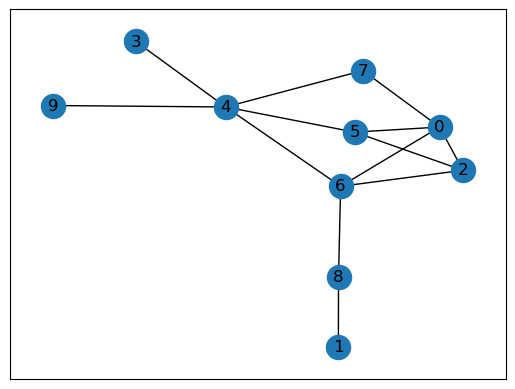

In [7]:
# create a binomial graph
import networkx as nx

# Create a graph
G = nx.erdos_renyi_graph(
    n=10, # number of nodes
    p=0.3, # probability of node connection
    directed=False #generated a directed graph?
) 

# visualize the graph
nx.draw_networkx(G)

In [8]:
# create a random walk function
import random

def random_walk(G: nx.Graph, start: int, length: int):
    
    """From `start` node, find `length` connected nodes"""
    
    # convert start node to string
    walk = [start]
    
    for i in range(length):
        neighbors = list(G.neighbors(start))
        next_node = random.choice(neighbors)
        walk.append(next_node)
        start = next_node
    
    return walk

# Create a list of random walks
random_walk(G, 6, 10)

[6, 8, 6, 0, 7, 0, 6, 8, 6, 0, 7]

# Deep walk

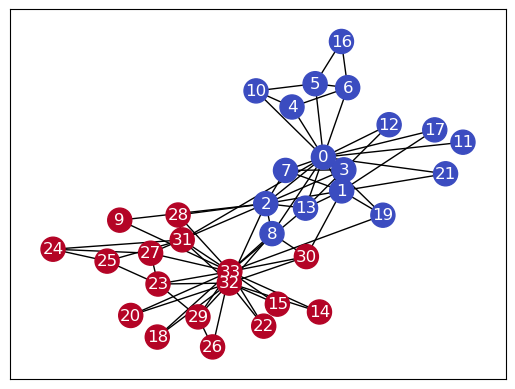

In [9]:
# Load karate dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot karate graph
nx.draw_networkx(
    G=G,
    node_color=labels,
    cmap='coolwarm',
    font_color = 'white'
)

In [10]:
# Create a list of random walks. For each node, perform 80 walks with lenght of 10
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(G=G, start=node, length=10))

walks[1]

[0, 11, 0, 5, 0, 1, 2, 28, 33, 8, 30]

In [11]:
# create Word2Vec model
model = Word2Vec(
    sentences=walks,
    hs=1,
    sg=1,
    vector_size=100,
    window=10,
    workers=1
)
model.wv.vectors.shape

(34, 100)

In [12]:
# build vocabulary
model.build_vocab(walks)

# train model
model.train(
    walks,
    total_examples=model.corpus_count,
    epochs=30,
    report_delay=1
)

(187033, 897600)

In [13]:
# most similar nodes
model.wv.most_similar(positive=[0])

[(10, 0.6698071956634521),
 (4, 0.6550989151000977),
 (17, 0.6515251398086548),
 (11, 0.6396676301956177),
 (3, 0.6266078948974609),
 (1, 0.6253778338432312),
 (12, 0.618133008480072),
 (7, 0.6109070777893066),
 (21, 0.5997698307037354),
 (5, 0.598929226398468)]

In [14]:
# similarity between two nodes
model.wv.similarity(0, 4)

0.65509886